In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

PY_FILE_LOC = os.getcwd()

In [3]:
# load the config
config_fn = os.path.join(PY_FILE_LOC, "config.json")
if os.path.exists(config_fn):
    with open(config_fn) as config_file:
        config = json.load(config_file)
else:
    config = dict()

In [4]:
from utils.nbutils_load_data import load_and_process_data
from utils.savefig import savefig_template

In [5]:
SAVE_FLAG = bool(config.get("save_figure"))
FIG_BASE_FOLDER = os.path.join(PY_FILE_LOC, "fig")
if not os.path.exists(FIG_BASE_FOLDER):
    os.mkdir(FIG_BASE_FOLDER)

def savefig(fig, fn, **kwargs):
    return savefig_template(SAVE_FLAG, FIG_BASE_FOLDER, fig, fn, **kwargs)

In [6]:
# Load Japan data
geo_map_folder = os.path.join(PY_FILE_LOC, "data", "map")
geo_fn = os.path.join(geo_map_folder, "jp_map_simple.geojson")
gdf = gpd.read_file(geo_fn)

# Append "県" to specific prefectures
prefectures = ["和歌山", "神奈川", "鹿児島"]
gdf["N03_001"] = gdf["N03_001"].apply(lambda x: x + "県" if x in prefectures else x)

# Correct a specific entry for "檮原町" to "梼原町"
gdf.loc[(gdf["N03_001"] == "高知県") & (gdf["N03_004"] == "檮原町"), "N03_004"] = (
    "梼原町"
)

# Reset index
gdf = gdf.reset_index()

# Load lake data
lake_geo_fn = os.path.join(geo_map_folder, "W09-05-g_Lake.shp")
lake_map_avail = os.path.exists(lake_geo_fn)
if lake_map_avail:
	gdf_lake = gpd.read_file(lake_geo_fn)
	gdf_lake = gdf_lake.set_crs(epsg=6668)
else:
	print("GIS data for lakes are not available.")

GIS data for lakes are not available.


In [7]:
# load the consolidated data
ftr_pref_muni = ["pref", "muni"]
folder = os.path.join(PY_FILE_LOC, "data")
pv_params, df = load_and_process_data(folder)
muni_index = pv_params[ftr_pref_muni].apply(tuple, axis=1)

# align the index
ftr_gdf_pref_muni = ["N03_001", "N03_004"]
gdf_muni = gdf[gdf[ftr_gdf_pref_muni].apply(tuple, axis=1).isin(muni_index)].copy()
gdf_muni = gdf_muni.drop_duplicates(ftr_gdf_pref_muni)[ftr_gdf_pref_muni + ["geometry"]]
gdf_muni = gdf_muni.rename(columns={"N03_001": "pref", "N03_004": "muni"})

# dissolve the cities and concatenate
ftr_gdf_pref_city = ["N03_001", "N03_003"]
gdf_major_cities = (
    gdf[gdf[ftr_gdf_pref_city].apply(tuple, axis=1).isin(muni_index)]
    .dissolve(by=ftr_gdf_pref_city, aggfunc="sum")["geometry"]
    .reset_index()
)
gdf_major_cities = gdf_major_cities.rename(
    columns={"N03_001": "pref", "N03_003": "muni"}
)
gdf_muni = pd.concat([gdf_muni, gdf_major_cities])

# merge with the 2023 data
gdf_muni = pd.concat(
    [
        gdf_muni.set_index(ftr_pref_muni),
        pv_params.set_index(ftr_pref_muni)[["demand", "PV_R_2023", "PV_S_2023", "PV_A_2023", "LV"]].div(1_000),
        pv_params.set_index(ftr_pref_muni)[["pv_out"]],
    ],
    axis=1,
)

gdf_muni.head(5)

geometry    demand  \
pref muni                                                                
北海道  函館市   POLYGON ((140.86691 42.00783, 140.87936 42.005...  1181.835   
     小樽市   POLYGON ((141.00973 43.23979, 141.01191 43.238...   671.998   
     旭川市   POLYGON ((142.25470 43.94876, 142.26217 43.944...  1505.444   
     室蘭市   POLYGON ((140.99563 42.43583, 141.00417 42.435...   867.362   
     釧路市   MULTIPOLYGON (((143.80405 43.12145, 143.80542 ...   879.857   

           PV_R_2023  PV_S_2023  PV_A_2023    LV       pv_out  
pref muni                                                      
北海道  函館市       7.609      5.906     27.423  43.0  1285.006554  
     小樽市       2.166      0.729     11.494  22.2  1306.230557  
     旭川市       9.465      2.431     22.253  24.3  1242.370221  
     室蘭市       3.223      2.228     16.595  20.0  1305.760949  
     釧路市      10.720     23.358    120.081  18.7  1304.394359

In [8]:
# calculate self-sufficiency rate
gdf_muni['pv_gen'] = gdf_muni['PV_A_2023']*gdf_muni['pv_out']
gdf_muni['self_suf_rate'] = gdf_muni['pv_gen']/1000/gdf_muni['demand']

gdf_muni['pv_gen_low'] = gdf_muni[['PV_R_2023']].sum(axis=1)*gdf_muni['pv_out']
gdf_muni['self_suf_rate_res'] = gdf_muni['pv_gen_low']/1000/gdf_muni['demand'].mul(0.3)

pv_pene_rate_2023 = gdf_muni['pv_gen'].div(1000).sum()/gdf_muni['demand'].sum()
print(f"Using the data in this study, the PV Penetration Rate of Japan in 2023 is {round(100*pv_pene_rate_2023,2)}% without curtailment.")

Using the data in this study, the PV Penetration Rate of Japan in 2023 is 11.13% without curtailment.


In [9]:
# ratio between the demand and pv_cap
mean_kwh_per_kw = 1240
fig_max_demand_twh = 3500
fig_max_pv_cap_mwh = 300
approx_solar_pene_rate = (fig_max_pv_cap_mwh*mean_kwh_per_kw)/(fig_max_demand_twh*1_000)
approx_solar_pene_rate

0.10628571428571429

In [10]:
gdf_muni['pene_rate'] = 100*gdf_muni['PV_A_2023']*gdf_muni['pv_out']/1_000/gdf_muni['demand']

cols = ['demand', "PV_A_2023", "pv_out", "pene_rate"]
gdf_muni[cols].sort_values('pene_rate', ascending=False)

demand  PV_A_2023       pv_out   pene_rate
pref muni                                            
岩手県  軽米町   47.649    162.017  1241.555597  422.156002
福島県  富岡町   32.600     99.633  1253.074858  382.968121
     川内村   19.219     59.277  1238.510654  381.992799
三重県  度会町   32.576     75.122  1386.208978  319.667212
群馬県  神流町    7.535     17.783  1350.380095  318.696871
...           ...        ...          ...         ...
鹿児島県 三島村    1.777      0.000  1208.482065    0.000000
沖縄県  北大東村   5.217      0.000  1208.577536    0.000000
     渡名喜村   2.061      0.000  1156.586505    0.000000
東京都  利島村    2.376      0.000  1334.807500    0.000000
     青ヶ島村   1.799      0.000  1265.934262    0.000000

[1741 rows x 4 columns]

In [11]:
muni_demand_gt_3500 = gdf_muni['demand'] > 3500
len(gdf_muni[muni_demand_gt_3500])

muni_pv_a_2023_gt_300 = gdf_muni["PV_A_2023"] > 300
len(gdf_muni[muni_pv_a_2023_gt_300])

number_muni_demand_gt_3000 = len(gdf_muni[muni_demand_gt_3500])
number_muni_pv_a_2023_gt_300 = len(gdf_muni[muni_pv_a_2023_gt_300])
number_muni_both = len(gdf_muni[muni_demand_gt_3500 & muni_pv_a_2023_gt_300])

print(
    f"Of the {len(gdf_muni)} municipalities in this study, only "
    f"{number_muni_demand_gt_3000} municipalities has demand greater than 3500 TWh/year and only "
    f"{number_muni_pv_a_2023_gt_300} municipalities has total PV capacity of than 300 MW." 

)

gdf_muni[muni_demand_gt_3500 & muni_pv_a_2023_gt_300]

Of the 1741 municipalities in this study, only 32 municipalities has demand greater than 3500 TWh/year and only 18 municipalities has total PV capacity of than 300 MW.


,,geometry,demand,PV_R_2023,PV_S_2023,PV_A_2023,LV,pv_out,pv_gen,self_suf_rate,pv_gen_low,self_suf_rate_res,pene_rate
pref,muni,,,,,,,,,,,,
兵庫県,姫路市,"MULTIPOLYGON (((134.48730 34.67123, 134.49043 ...",5816.063,87.023,84.857,392.562,68.5,1338.620446,525491.519389,0.090352,116490.767043,0.066764,9.035176
大分県,大分市,"POLYGON ((131.68197 33.27925, 131.69195 33.279...",4331.048,88.246,59.917,401.322,57.1,1342.346928,538713.353771,0.124384,118456.746993,0.091169,12.438406
兵庫県,神戸市,"MULTIPOLYGON (((135.08253 34.63267, 135.08238 ...",9221.530,101.482,41.779,305.996,156.1,1326.984531,406051.958686,0.044033,134665.044221,0.048678,4.403304
宮城県,仙台市,"POLYGON ((140.96772 38.19098, 140.96026 38.175...",6095.535,102.329,36.528,366.948,78.1,1189.722432,436566.266825,0.071621,121743.106702,0.066575,7.162066
岡山県,岡山市,"POLYGON ((133.99580 34.61354, 133.98089 34.606...",4493.413,87.615,127.164,362.855,65.8,1379.323988,500494.605646,0.111384,120849.471204,0.089649,11.138406
福岡県,北九州市,"MULTIPOLYGON (((130.97626 33.84183, 130.97750 ...",6970.201,99.750,40.858,321.864,64.7,1264.298251,406932.092113,0.058382,126113.750492,0.060311,5.838169
静岡県,浜松市,"POLYGON ((137.80041 34.69760, 137.79533 34.698...",4875.027,161.435,226.312,667.879,68.5,1350.125258,901720.307189,0.184967,217957.471026,0.149030,18.496724


In [12]:
representative_muni_cnt = int(1741 * 0.25)
representative_muni_df = (
    gdf_muni.sort_values("demand", ascending=False)
    .head(representative_muni_cnt)
)
representative_muni_self_suf_rate_mean = representative_muni_df["self_suf_rate"].mean()
rep_demand_vs_jp_demand_share = representative_muni_df['demand'].sum()/gdf_muni['demand'].sum()


print(f"The average PV penetration rate of the top 25% of the municipalities sorted by demand ({representative_muni_cnt} of 1741)" 
f" is already at {round(100*representative_muni_self_suf_rate_mean,2)}%. \n"
f"These municipalities represent {round(100*rep_demand_vs_jp_demand_share, 2)}% of the total electricity demand of Japan.")

The average PV penetration rate of the top 25% of the municipalities sorted by demand (435 of 1741) is already at 10.81%. 
These municipalities represent 78.26% of the total electricity demand of Japan.


In [13]:
representative_muni_df.sort_values("self_suf_rate_res", ascending=False).head(20)

geometry    demand  \
pref muni                                                                  
長野県  佐久市     POLYGON ((138.49058 36.31548, 138.48698 36.311...   643.029   
     飯田市     POLYGON ((137.80842 35.64140, 137.81209 35.641...   587.145   
愛知県  一宮市     POLYGON ((136.77464 35.36960, 136.79446 35.368...  1582.485   
山梨県  南アルプス市  POLYGON ((138.23432 35.74532, 138.23430 35.737...   493.617   
宮崎県  延岡市     MULTIPOLYGON (((131.76875 32.83701, 131.78721 ...   576.661   
長野県  安曇野市    POLYGON ((137.72955 36.42532, 137.74011 36.419...   648.354   
静岡県  藤枝市     POLYGON ((138.21526 35.01547, 138.21691 35.010...   810.959   
宮崎県  都城市     POLYGON ((131.18257 31.94180, 131.19479 31.939...  1130.135   
鹿児島県 鹿屋市     POLYGON ((130.85760 31.61496, 130.85914 31.615...   591.050   
愛知県  日進市     POLYGON ((137.05917 35.16788, 137.05858 35.163...   485.119   
長野県  松本市     POLYGON ((138.05548 36.37721, 138.06149 36.375...  1385.272   
愛媛県  新居浜市    MULTIPOLYGON (((133.32149 33.99421, 133.32611 ...   579.475   
長野県  上田市     POLYGON ((138.38207 36.55466, 138.39155 36.553...  1046.132   
宮崎県  宮崎市     POLYGON ((131.42515 32.05263, 131.43208 32.053...  2245.226   
愛媛県  松山市     MULTIPOLYGON (((132.55016 33.93809, 132.55446 ...  2552.930   
静岡県  三島市     POLYGON ((139.00178 35.18953, 139.00934 35.183...   511.218   
佐賀県  佐賀市     POLYGON ((130.20426 33.48133, 130.21278 33.480...  1349.483   
山口県  山口市     POLYGON ((131.66127 34.50333, 131.66553 34.502...  1100.106   
愛知県  瀬戸市     POLYGON ((137.10847 35.30008, 137.12884 35.294...   674.505   
熊本県  合志市     POLYGON ((130.72981 32.92741, 130.73532 32.925...   590.615   

             PV_R_2023  PV_S_2023  PV_A_2023     LV       pv_out  \
pref muni                                                          
長野県  佐久市        29.889     43.210    136.949   29.2  1367.216727   
     飯田市        25.835     26.770     69.312   27.1  1390.887405   
愛知県  一宮市        69.446     48.581    129.395   79.0  1334.737280   
山梨県  南アルプス市     20.306     32.281     77.723   28.4  1417.183609   
宮崎県  延岡市        24.168     28.377     80.938   28.1  1343.716507   
長野県  安曇野市       25.616     17.097     59.678   26.4  1425.057462   
静岡県  藤枝市        32.901     21.677     65.032   72.2  1372.659066   
宮崎県  都城市        47.456    105.698    240.133   19.8  1289.189536   
鹿児島県 鹿屋市        24.283     99.761    216.884   10.9  1270.350996   
愛知県  日進市        18.597      7.031     29.338  100.3  1345.327967   
長野県  松本市        50.044     42.368    118.471   29.0  1425.057462   
愛媛県  新居浜市       21.533     26.473    126.832   40.4  1367.575621   
長野県  上田市        39.741     54.246    121.685   36.2  1323.679961   
宮崎県  宮崎市        86.873    101.931    474.588   27.9  1294.784151   
愛媛県  松山市        90.822     53.329    218.826   93.4  1379.392168   
静岡県  三島市        19.180      6.766     27.396  122.9  1273.278878   
佐賀県  佐賀市        52.070     47.861    127.293   36.1  1232.951253   
山口県  山口市        40.220     58.137    214.748   31.1  1298.555281   
愛知県  瀬戸市        23.674     15.066     83.925   65.9  1345.327967   
熊本県  合志市        22.379     12.655     50.358   48.9  1240.277804   

                    pv_gen  self_suf_rate     pv_gen_low  self_suf_rate_res  \
pref muni                                                                     
長野県  佐久市     187238.963533       0.291183   40864.740750           0.211835   
     飯田市      96405.187801       0.164193   35933.576103           0.204002   
愛知県  一宮市     172708.330300       0.109137   92692.165122           0.195246   
山梨県  南アルプス市  110147.761673       0.223144   28777.330372           0.194330   
宮崎県  延岡市     108757.726668       0.188599   32474.940548           0.187718   
長野県  安曇野市     85044.579194       0.131170   36504.271937           0.187677   
静岡県  藤枝市      89266.764350       0.110076   45161.855915           0.185631   
宮崎県  都城市     309576.950791       0.273929   61179.778609           0.180450   
鹿児島県 鹿屋市     275518.805372       0.466151   30847.933231           0.173972   
愛知県  日進市      3

In [14]:
representative_muni_cnt = 1741 - int(1741 * 0.25)
representative_muni_df = (
    gdf_muni.sort_values("demand", ascending=False)
    .tail(representative_muni_cnt)
)
representative_muni_self_suf_rate_mean = representative_muni_df["self_suf_rate"].mean()
rep_demand_vs_jp_demand_share = representative_muni_df['demand'].sum()/gdf_muni['demand'].sum()


print(f"In contrast, the average PV penetration rate of the bottom 75% of the municipalities sorted by demand ({representative_muni_cnt} of 1741)" 
f" is already at {round(100*representative_muni_self_suf_rate_mean,2)}%. \n"
f"These municipalities represent {round(100*rep_demand_vs_jp_demand_share, 2)}% of the total electricity demand of Japan.")

In contrast, the average PV penetration rate of the bottom 75% of the municipalities sorted by demand (1306 of 1741) is already at 25.7%. 
These municipalities represent 21.74% of the total electricity demand of Japan.


In [15]:
representative_muni_df.sort_values("self_suf_rate_res", ascending=False).head(20)

geometry   demand  \
pref muni                                                               
長野県  北相木村  POLYGON ((138.60278 36.09728, 138.60776 36.096...    2.529   
福島県  葛尾村   POLYGON ((140.75722 37.54331, 140.76248 37.541...    4.337   
宮崎県  三股町   POLYGON ((131.24063 31.79743, 131.23737 31.784...  118.689   
長野県  原村    POLYGON ((138.22516 35.98466, 138.23783 35.984...   37.980   
     泰阜村   POLYGON ((137.81716 35.41775, 137.82260 35.418...    6.558   
宮崎県  日之影町  POLYGON ((131.47786 32.83368, 131.48600 32.821...   16.744   
長野県  喬木村   POLYGON ((137.87983 35.53000, 137.89616 35.523...   26.344   
熊本県  湯前町   POLYGON ((131.02870 32.30368, 131.03398 32.304...   15.376   
     益城町   POLYGON ((130.87502 32.83671, 130.88037 32.818...  164.764   
佐賀県  白石町   POLYGON ((130.11129 33.20263, 130.12813 33.196...   97.818   
山梨県  甲斐市   POLYGON ((138.53101 35.80535, 138.53819 35.801...  296.796   
福岡県  福津市   POLYGON ((130.48189 33.84972, 130.48506 33.840...  243.395   
熊本県  御船町   POLYGON ((130.95276 32.78981, 130.95488 32.789...   79.850   
福岡県  岡垣町   POLYGON ((130.56400 33.89132, 130.56830 33.886...  121.211   
熊本県  甲佐町   POLYGON ((130.76051 32.72034, 130.76571 32.719...   49.414   
     氷川町   POLYGON ((130.62998 32.62284, 130.64131 32.614...   46.862   
長野県  高森町   POLYGON ((137.83474 35.60533, 137.83907 35.605...   77.077   
     朝日村   POLYGON ((137.87955 36.14834, 137.88202 36.148...   22.834   
     佐久穂町  POLYGON ((138.48873 36.17353, 138.48854 36.171...   51.323   
和歌山県 日高町   POLYGON ((135.17656 33.98198, 135.17791 33.978...   35.007   

           PV_R_2023  PV_S_2023  PV_A_2023    LV       pv_out         pv_gen  \
pref muni                                                                      
長野県  北相木村      0.609      0.605      2.214   4.3  1405.172728    3111.052421   
福島県  葛尾村       0.450      2.594      3.044   4.3  1212.124472    3689.706893   
宮崎県  三股町       9.652     11.388     31.622  17.9  1312.090398   41490.922574   
長野県  原村        2.635      4.517      9.157  18.0  1426.227869   13059.968601   
     泰阜村       0.472      0.406      0.878   2.3  1363.193927    1196.884268   
宮崎県  日之影町      1.239      0.515      1.754   4.8  1320.358577    2315.908944   
長野県  喬木村       1.769      2.573      5.092  14.8  1390.887405    7082.398665   
熊本県  湯前町       1.112      1.906      4.012   7.6  1273.854302    5110.703461   
     益城町      11.973      5.470     81.262  43.5  1248.479972  101453.979521   
佐賀県  白石町       6.969     10.030     20.305  12.4  1232.951253   25035.075186   
山梨県  甲斐市      18.372     20.584    104.671  41.4  1387.003848  145179.079803   
福岡県  福津市      16.183      6.033     48.556  37.9  1266.452508   61493.867979   
熊本県  御船町       5.349      4.389     18.720  25.7  1248.479972   23371.545084   
福岡県  岡垣町       8.002      3.986     18.282  25.3  1266.452508   23153.284752   
熊本県  甲佐町       3.282      4.694     16.600  17.7  1248.479972   20724.767543   
     氷川町       3.062      4.950      9.920  14.1  1253.541225   12435.128949   
長野県  高森町       4.578      5.009     14.399  18.0  1366.731564   19679.567791   
     朝日村       1.326      1.222      7.986  16.8  1393.527934   11128.714078   
     佐久穂町      2.919      4.834      9.236  21.6  1405.172728   12978.175319   
和歌山県 日高町       2.009      4.996      8.209  27.7  1376.989987   11303.710807   

           self_suf_rate    pv_gen_low  self_suf_rate_res   pene_rate  
pref muni                                                              
長野県  北相木村       1.230151    855.750192           1.127916  123.015121  
福島県  葛尾村        0.850751    545.456013           0.419227   85.075096  
宮崎県  三股町        0.349577  12664.296524           0.355672   34.957681  
長野県  原村         0.343864   3758.110436           0.329832   34.386437  
     泰阜村        0.182508    643.427534           0.327045   18.250751  
宮崎県  日之影町       0.138313   1635.924277           0.325674   13.831277  
長野県  喬木村        0.268843   2460.479819           0.311327   26.884295  
熊本県  湯前町        0.332382   1416.5259

In [16]:
def plot_color_bar_legend(
    fig,
    ax,
    label,
    cmap,
    vmin,
    vmax,
    orientation="horizontal",
    fraction=0.025,
    pad=0.04,
    location="bottom",
    anchor=(0.5, 0.0),
    panchor=(1.0, 0.5),
):
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(
            norm=plt.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap,
        ),
        ax=ax,
        orientation=orientation,
        fraction=fraction,
        pad=pad,
        location=location,
        panchor=panchor,
        anchor=anchor,
    )
    cbar.set_label(label)


def plot_data_cmap(
    fig, ax, column, label, vmin, vmax, cmap=None, anchor=None, panchor=None
):
    if cmap is None:
        cmap = "RdYlGn_r"
    gdf_muni.plot(
        ax=ax,
        column=column,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=False,
    )

    if anchor is None:
        anchor = (0.75, 0.0)
    if panchor is None:
        panchor = (0.5, -2)

    plot_color_bar_legend(
        fig,
        ax,
        label,
        cmap,
        vmin,
        vmax,
        location="bottom",
        anchor=anchor,
        panchor=panchor,
    )
    if lake_map_avail:
    	gdf_lake.plot(ax=ax, color="white")
    ax.set_ylim(30, 46)
    ax.set_xlim(128, 146)
    ax.axis("off")

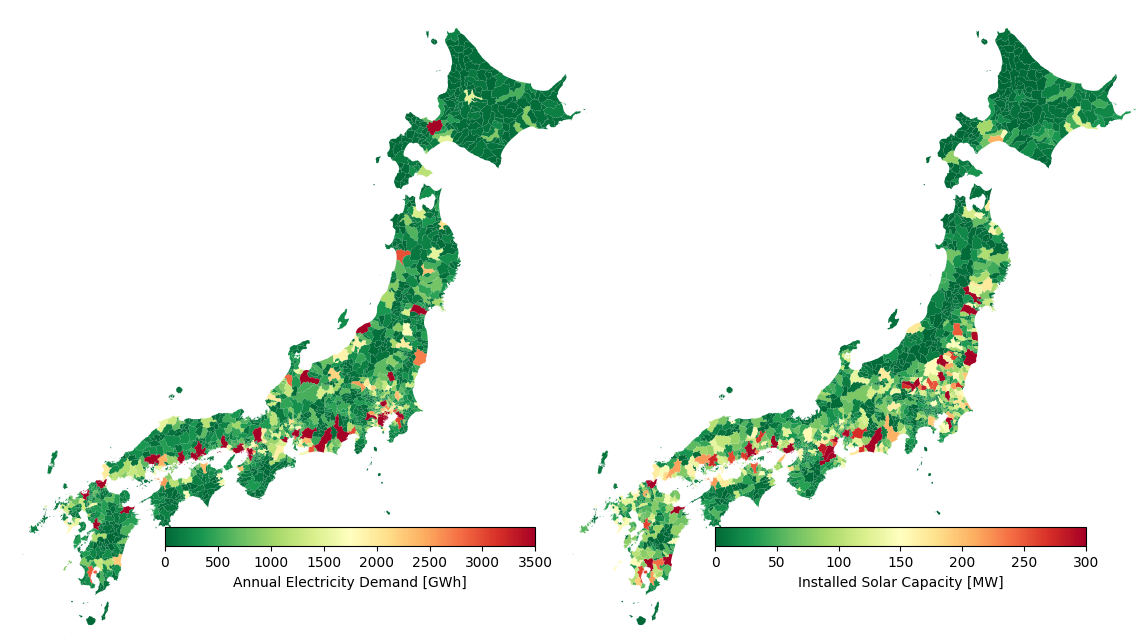

In [17]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 8)
plt.tight_layout(w_pad=-5)

plot_data_cmap(
    fig,
    axs[0],
    column="demand",
    label="Annual Electricity Demand [GWh]",
    vmin=0,
    vmax=3_500,
)
plot_data_cmap(
    fig,
    axs[1],
    column="PV_A_2023",
    label="Installed Solar Capacity [MW]",
    vmin=0,
    vmax=300,
)

savefig(fig, "demand_vs_pv_cap.svg")

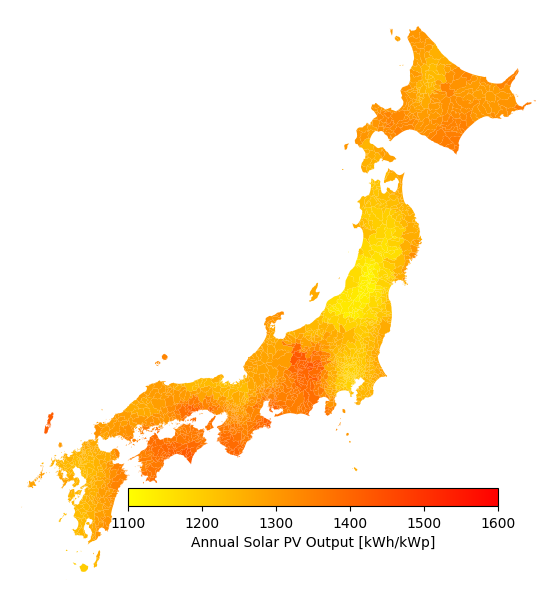

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 8)
plt.tight_layout(w_pad=-5)

plot_data_cmap(
    fig,
    ax,
    column="pv_out",
    label="Annual Solar PV Output [kWh/kWp]",
    vmin=1100,
    vmax=1600,
    # anchor=anchor,
    cmap="autumn_r",
    panchor=(0.5, -1),
)

savefig(fig, fn="annual_pv_output.svg")

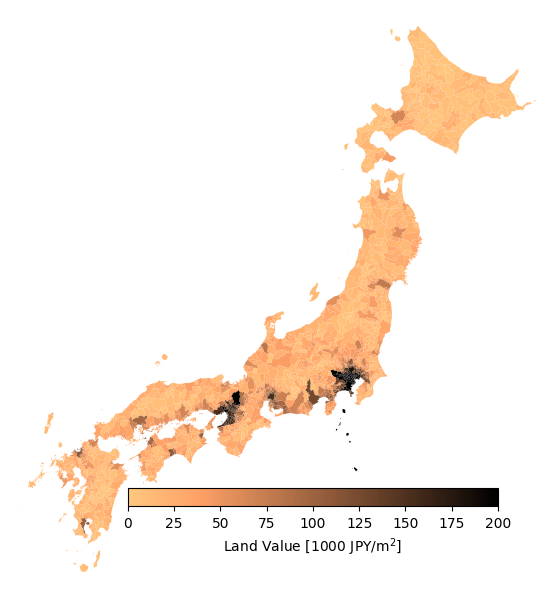

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 8)
plt.tight_layout(w_pad=-5)

plot_data_cmap(
    fig,
    ax,
    column="LV",
    label="Land Value [1000 JPY/m$^2$]",
    vmin=0,
    vmax=200,
    # anchor=anchor,
    cmap="copper_r",
    panchor=(0.5, -1),
)

savefig(fig, fn="land_value.svg")